In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#### Initialize Input Vectors, activation functions and helper functions

In [2]:
"""
activation functions and their derivatives
"""

def relu_k(x, k):
    return np.maximum(x**k, 0)

def d_relu_k(x, k):
    return k * x**(k-1) * (x > 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def sin(x, k=None):
    return np.sin(x)

def cos(x, k=None):
    return np.cos(x)

def d_cos(x, k=None):
    return -np.sin(x)

In [3]:
def init_inputs(num_inputs=200):
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniformly sampled
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * np.pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta))) # (2, 100)
    return x

In [4]:
# check kernel symmetry and positive definitiveness
def check(matrix, tol=1e-10):
    if not np.all(np.abs(matrix-matrix.T) < tol):
        print("warning: kernel is not symmetric")
    if not np.all(np.linalg.eigvals(matrix) >= -tol):
        print("warning: kernel is not positive semi-definite")

#### Analytical Solution for ReLU NTK

In [5]:
"""
analytic solution: Equation (4)-(5) on page 3

u = <x, x'> / ||x|| ||x'||

k(u) = u k_0(u) + k_1(u)

k_0 = 1/pi (pi - arccos(u))
k_1 = 1/pi (u (pi - arccos(u)) + sqrt(1 - u^2))

assuming x == x'

norm = np.linalg.norm(x, axis=0) # (100,)
norm_prod = np.outer(norm, norm) # (100, 100)
but norms are all 1 in theory but their numerical values are unstable
so we don't include norm_prod in the actual calculation
"""

def kappa(u):
    pi = np.pi
    k_0 = (1/pi) * (pi - np.arccos(u))
    k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))
    return u * k_0 + k_1

def calc_NTK_analytical():
    x = init_inputs() # (2, 100)

    inner_prod = np.dot(x.T, x) # (100, 100)
    inner_prod[inner_prod > 1.0] = 1.0 # numerical fix => values slightly > 1 will be capped

    u = inner_prod
    kernel = kappa(u)
    check(kernel)
    
    return kernel

#### Numerical Approximation for ReLU NTK

In [6]:
def calc_NTK_numerical(activation='relu_k', k=1):
    """
    numerical kernel calculation - vectorized version

    https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf
    equation (3) on page 3 and section 3.3 on page 7 

    x, y are vectors
    activation = ['relu_k', 'sin', 'cos']
    d_activation is the derivative of activation function

    k=1 means regular relu

    K(x, x') = <x, x'> E[sig'(<w, x>)sig'(<w, x'>)] + E[sig(<w, x>)sig(<w, x'>)]
    E {w ~ N(0, 1)}

    """
    # init input
    x = init_inputs() # (2, 100)
    
    num_inputs = x.shape[1]
    # init kernel and weight
    kernel = np.zeros((num_inputs, num_inputs))
    num_samples = 40000
    w1, w2 = np.random.normal(0.0, 1.0, size=[2, num_samples, 2]) # (1000, 2)

    xx = np.dot(x.T, x) #(100, 100)
    xx[xx > 1.0] = 1.0

    w1x = np.dot(w1, x) # (num_samples, 100)
    w2x = np.dot(w2, x) # (num_samples, 100)

    if activation == 'relu_k':
        activation_func = relu_k
        d_activation = d_relu_k
    elif activation == 'sin':
        activation_func = sin
        d_activation = cos
    elif activation == 'cos':
        activation_func = cos
        d_activation = d_cos        

    sigma_w1x = np.asarray(activation_func(w1x, k)) # (num_samples, 100)
    sigma_w2x = np.asarray(d_activation(w2x, k))    # (num_samples, 100)

    expection_1 = np.dot(sigma_w1x.T, sigma_w1x) / num_samples
    expection_2 = np.dot(sigma_w2x.T, sigma_w2x) / num_samples

    kernel = 2 * xx * expection_2 + 2 * expection_1
   
    check(kernel)
    
    return kernel

#### Numerical Approximation to Laplace Kernel 

In [7]:
# calculate Laplace Kernel

def laplace_kernel_entry(x, y, alpha, sigma):
    """
    x are y in R^2

    K(x, y) = exp(-||x - y||^a / sigma)
    
    TODO: define |x-y|^alpha
    find alpha that matches slope of ReLU k decay for different k
    
    k=1 ----> alpha = 1
    k=2 ----> alpha = ?
    k=n ----> alpha = f(n)
    """
    norm = np.linalg.norm(x - y)
    return np.exp(-norm**alpha / sigma)

# execute
def calc_laplace(alpha=1.0, sigma=1.0):
    x = init_inputs()
    num_inputs = x.shape[1]
    # init kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = laplace_kernel_entry(x[:, i], x[:, j], alpha, sigma)
    
    check(kernel)
    
    return kernel

#### Numerical Approximation to Laplace Kernel 

In [8]:
# calculate Laplace Kernel

def gaussian_kernel_entry(x, y, sigma):
    """
    x are y in R^2

    K(x, y) = exp(-||x - y||^2 / 2*(sigma**2))

    plot gaussian too and compare with sin/cos
    """
    norm = np.linalg.norm(x - y)
    return np.exp(-norm**2 / 2 * (sigma**2))

# execute
def calc_gaussian(sigma=1.0):
    x = init_inputs()
    num_inputs = x.shape[1]
    # init kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = gaussian_kernel_entry(x[:, i], x[:, j], sigma)
    
    check(kernel)
    
    return kernel

#### Plot Functionality

In [9]:
def plot_eigendecay(kernel, label):
    # plot
    eigenvalues = np.linalg.eigvals(kernel)
    # sort in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    plt.loglog(sorted_eigenvalues[:-1], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_eigendecay_trig(kernel, label):
    # plot
    eigenvalues = np.linalg.eigvals(kernel)
    # sort in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    plt.yscale('log')
    plt.plot(sorted_eigenvalues[:-100], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Plot ReLU Activated Kernel Eigenvalue Decays

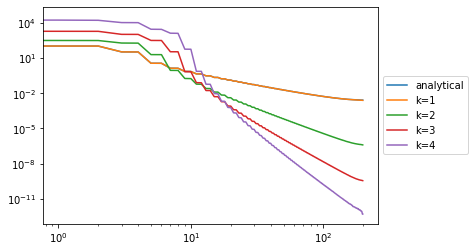

In [10]:
kernel_analytical = calc_NTK_analytical()
kernel_k1 = calc_NTK_numerical(k=1)
kernel_k2 = calc_NTK_numerical(k=2)
kernel_k3 = calc_NTK_numerical(k=3)
kernel_k4 = calc_NTK_numerical(k=4)

plot_eigendecay(kernel_analytical, 'analytical')
plot_eigendecay(kernel_k1, 'k=1')
plot_eigendecay(kernel_k2, 'k=2')
plot_eigendecay(kernel_k3, 'k=3')
plot_eigendecay(kernel_k4, 'k=4')

#### Plot Sine/Cosine Activated Kernel Eigenvalue Decays

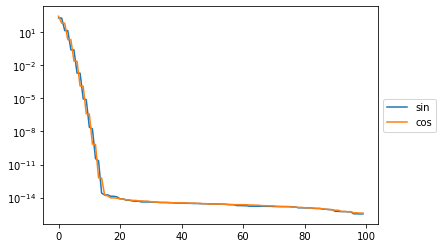

In [11]:
kernel_sin = calc_NTK_numerical('sin')
kernel_cos = calc_NTK_numerical('cos')

plot_eigendecay_trig(kernel_sin, 'sin')
plot_eigendecay_trig(kernel_cos, 'cos')

#### Preliminary Plot Comparison:
Laplace <-> ReLU and Gaussian <-> Trig 

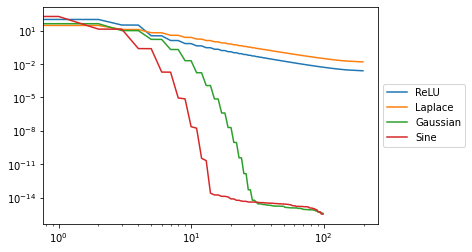

In [12]:
kernel_laplace_a1 = calc_laplace(alpha=1)
kernel_gaussian = calc_gaussian()

plot_eigendecay(kernel_analytical, 'ReLU')
plot_eigendecay(kernel_laplace_a1, 'Laplace')
plot_eigendecay_trig(kernel_gaussian, 'Gaussian')
plot_eigendecay_trig(kernel_sin, 'Sine')

#### Utility functions to calculate rate/slope of decay under log-log scales and tune alpha parameter

In [40]:
"""
the naive approach takes two end points and calculate the slope:
    calculate slope:
    (x1, y1) => (x2, y2)
    where x1 = 20, x2 = 100 
    y values are eigenvalues[20], eigenvalues[100]
the regression approach fits a linear regression with all the eigenvalues in [20:100]

log(y) = k * log(x) + log(b)

returns k
"""
def calc_slope_naive(kernel):
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    x1 = 20
    x2 = 100
    y1 = np.log2(sorted_eigenvalues[20])
    y2 = np.log2(sorted_eigenvalues[100])
    
    slope = (y2-y1) / (x2-x1)
    b = y1 - slope * x1
    
    return slope

def calc_slope_regression(kernel):
    """ the range between two end points may be adjusted"""
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    x = np.log10(np.arange(30, 100))
    y = np.log10(sorted_eigenvalues[30:100])
    
    slope, b = np.polyfit(x, y, deg=1)
    
    return slope

In [41]:
"""
given k, calculate closest corresponding alpha value
a, b are lower and upper bound for the parameter tuning range
fit = ['regression', 'naive']
"""
def closest_alpha_with_k(k, a, b, fit='regression'):
    
    if fit == 'regression':
        calc_slope = calc_slope_regression
    elif fit == 'naive':
        calc_slope = calc_slope_naive
    
    # calculate the target decay for ReLU^k
    kernel = calc_NTK_numerical(k=k)
    plot_eigendecay(kernel, f'k={k}')
    slope_list = []
    
    # store target slope value
    target_slope = calc_slope(kernel)
    slope_list.append((target_slope, f'k={k}'))

    # tuning alpha and record the one that has the closest slope with target 
    alpha_list = np.linspace(a, b, 15)
    
    min_diff = 9999
    closest_alpha = 0
    closest_kernel = np.zeros_like(kernel)

    for alpha in tqdm(alpha_list):
        
        kernel_ = calc_laplace(alpha)
        competing_slope = calc_slope(kernel_)
        slope_list.append((competing_slope, f'a={alpha}'))
        plot_eigendecay(kernel_, f'a={alpha}')
        
        # update closest alpha
        if np.abs(competing_slope - target_slope) < min_diff:
            min_diff = np.abs(competing_slope - target_slope)
            closest_alpha = alpha
            closest_kernel = kernel_
            
    plot_eigendecay(closest_kernel, f'a={closest_alpha}')

    display(closest_alpha)
    # conclusion: k=1 matches alpha=1, but computation shows otherwise. TODO: fix bug
    return slope_list

#### Finding the Relationship Between alpha and k

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.15it/s]


1.0642857142857143

[(-1.9079181472583113, 'k=1'),
 (-1.8230491622227873, 'a=1.0'),
 (-1.8327503916958743, 'a=1.0071428571428571'),
 (-1.8424199522143418, 'a=1.0142857142857142'),
 (-1.8520581575047474, 'a=1.0214285714285714'),
 (-1.8616653180387785, 'a=1.0285714285714287'),
 (-1.8712417410692996, 'a=1.0357142857142858'),
 (-1.8807877306666119, 'a=1.042857142857143'),
 (-1.8903035877549426, 'a=1.05'),
 (-1.8997896101490523, 'a=1.0571428571428572'),
 (-1.9092460925909718, 'a=1.0642857142857143'),
 (-1.9186733267866818, 'a=1.0714285714285714'),
 (-1.9280716014428463, 'a=1.0785714285714287'),
 (-1.937441202303482, 'a=1.0857142857142859'),
 (-1.9467824121864585, 'a=1.092857142857143'),
 (-1.9560955110199019, 'a=1.1')]

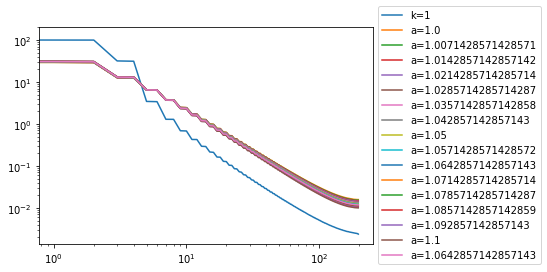

In [42]:
closest_alpha_with_k(k=1, a=1.0, b=1.1)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.20it/s]


1.999999999

[(-4.199485732581597, 'k=2'),
 (-1.9560955110199019, 'a=1.1'),
 (-2.038693207164961, 'a=1.1642857142142857'),
 (-2.1192270582492583, 'a=1.2285714284285716'),
 (-2.1978728160063685, 'a=1.2928571426428572'),
 (-2.27479159236842, 'a=1.3571428568571429'),
 (-2.3501314776258804, 'a=1.4214285710714285'),
 (-2.424028944859017, 'a=1.4857142852857144'),
 (-2.496610061122638, 'a=1.5499999995'),
 (-2.5679915310502555, 'a=1.6142857137142856'),
 (-2.6382815985911945, 'a=1.6785714279285715'),
 (-2.707580830411219, 'a=1.7428571421428571'),
 (-2.775982802173924, 'a=1.8071428563571428'),
 (-2.843574710635829, 'a=1.8714285705714286'),
 (-2.9104379730963714, 'a=1.9357142847857143'),
 ((-3.007952905707391+0j), 'a=1.999999999')]

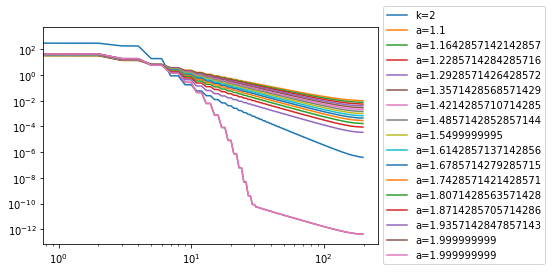

In [43]:
closest_alpha_with_k(k=2, a=1.1, b=1.999999999)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.93it/s]


1.999999999

[(-4.203578706012708, 'k=2'),
 (-2.97666078921154, 'a=1.99999'),
 (-2.976662153478152, 'a=1.9999907142142856'),
 (-2.976663584644977, 'a=1.9999914284285714'),
 (-2.9766651131893482, 'a=1.999992142642857'),
 (-2.976666772142822, 'a=1.9999928568571428'),
 (-2.976668591777074, 'a=1.9999935710714285'),
 (-2.9766706242723737, 'a=1.9999942852857142'),
 (-2.9766729465181267, 'a=1.9999949995'),
 (-2.976675704496836, 'a=1.9999957137142856'),
 (-2.976679071239418, 'a=1.9999964279285714'),
 (-2.976683579880013, 'a=1.999997142142857'),
 (-2.9766902392243875, 'a=1.9999978563571428'),
 (-2.976701860845024, 'a=1.9999985705714285'),
 (-2.976732488494954, 'a=1.9999992847857142'),
 ((-3.007952905707394+0j), 'a=1.999999999')]

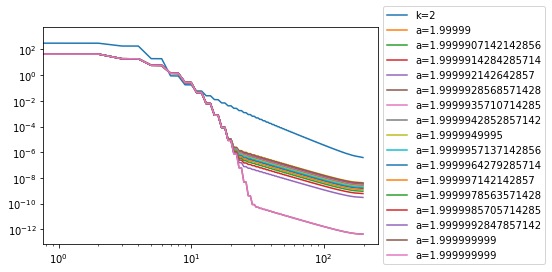

In [17]:
closest_alpha_with_k(k=2, a=1.99999, b=1.999999999)

In [30]:
# tuning sigma for laplace
"""
We conclude numerically that different sigma values
do not affect the slope of the eigenvalue decay
"""

sigma_list = np.linspace(1.0, 20.0, 5)
slope_list = []

for sig in tqdm(sigma_list):
    kernel_ = calc_laplace(alpha=1, sigma=sig)
    slope_list.append((calc_slope_regression(kernel_), f's={sig}'))
    
slope_list


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


[(-1.8230491622227862, 's=1.0'),
 (-1.825753485755331, 's=5.75'),
 (-1.825812658221229, 's=10.5'),
 (-1.8258259908110401, 's=15.25'),
 (-1.825831022008592, 's=20.0')]

#### Make a scatter plot of alpha vs slope for laplace kernels

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.20it/s]


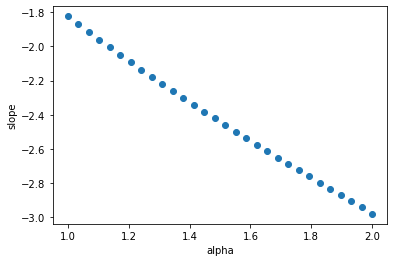

In [47]:
"""
Make a scatter plot of alpha vs slope for laplace kernels
"""

alpha_list = np.linspace(1.0, 1.99999999, 30)
slope_list = []

for a in tqdm(alpha_list):
    kernel_ = calc_laplace(alpha=a)
    slope_list.append(calc_slope_regression(kernel_))
    # plot_eigendecay(kernel_, f'a={a}')

plt.xlabel("alpha")
plt.ylabel("slope")
plt.scatter(alpha_list, slope_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


[-1.9068854106749642,
 -4.2009810272375905,
 -6.456176825723801,
 (-8.800232544174152+0j),
 (-11.11626101147935+0.006191131742986889j)]

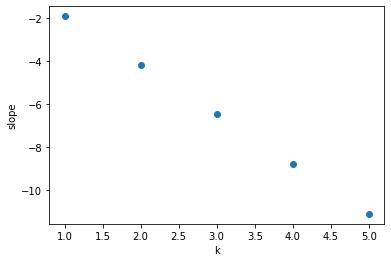

In [52]:
"""
Make a scatter plot of k value vs slope for ReLU^k kernels
"""

k_list = np.array([1, 2, 3, 4, 5])
slope_list = []

for k in tqdm(k_list):
    kernel_ = calc_NTK_numerical(k=k)
    slope_list.append(calc_slope_regression(kernel_))
    # plot_eigendecay(kernel_, f's={sig}')
    
display(slope_list)

plt.xlabel("k")
plt.ylabel("slope")
plt.scatter(k_list, slope_list)